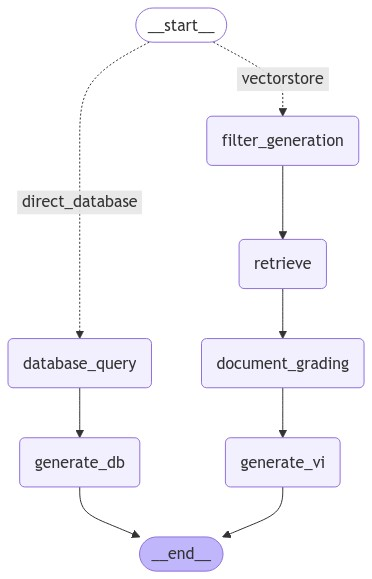

In [2]:
import logging, json
from typing import List, Optional
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START
from metadata_chatbot.agents.docdb_retriever import DocDBRetriever

#from agentic_graph import datasource_router, query_retriever, filter_generation_chain, doc_grader, rag_chain, db_rag_chain
from metadata_chatbot.agents.agentic_graph import datasource_router, query_retriever, filter_generation_chain, doc_grader, rag_chain, db_rag_chain

logging.basicConfig(filename='async_workflow.log', level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', filemode="w")

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        query: question asked by user
        generation: LLM generation
        documents: list of documents
    """

    query: str
    generation: str
    documents: List[str]
    filter: Optional[dict]
    #top_k: Optional[int] 

def route_question(state):
    """
    Route question to database or vectorstore
    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    query = state["query"]

    source = datasource_router.invoke({"query": query})
    if source.datasource == "direct_database":
        logging.info("Entire database needs to be queried.")
        return "direct_database"
    elif source.datasource == "vectorstore":
        logging.info("Querying against vector embeddings...")
        return "vectorstore"

def retrieve_DB(state):
    """
    Filter database
    
    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key may be added to state, generation, which contains the answer for query asked
    """

    query = state['query']

    logging.info("Generating answer...")

    document_dict = dict()
    retrieved_dict = query_retriever.invoke({'query': query, 'chat_history': [], 'agent_scratchpad' : []})
    document_dict['mongodb_query'] = retrieved_dict['intermediate_steps'][0][0].tool_input['agg_pipeline']
    document_dict['retrieved_output'] = retrieved_dict['intermediate_steps'][0][1]

    documents = json.dumps(document_dict)
    return {"query": query, "documents": documents}

def filter_generator(state):
    """
    Filter database

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key may be added to states, filter and top_k, which contains the MongoDB query that will be applied before retrieval
    """
    logging.info("Determining whether filter is required...")

    query = state["query"]

    # query_grade = query_grader.invoke({"query": query}).binary_score
    # logging.info(f"Database needs to be further filtered: {query_grade}")

    #if query_grade == "yes":
    filter = filter_generation_chain.invoke({"query": query}).filter_query
    #top_k = filter_generation_chain.invoke({"query": query}).top_k
    logging.info(f"Database will be filtered using: {filter}")
    return {"filter": filter, "query": query}
    # else:
    #     return {"filter": None, "query": query}

def retrieve_VI(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    logging.info("Retrieving documents...")
    query = state["query"]
    filter = state["filter"]
    #top_k = state["top_k"]

    retriever = DocDBRetriever(k = 5)
    documents = retriever.get_relevant_documents(query = query, query_filter = filter)

    # # Retrieval
    # with ResourceManager() as RM:
    #     collection = RM.client['metadata_vector_index']['LANGCHAIN_ALL_curated_assets']
    #     retriever = DocDBRetriever(collection = collection, k = top_k)
    #     documents = retriever.get_relevant_documents(query = query, query_filter = filter)
    return {"documents": documents, "query": query}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    logging.info("Checking relevance of documents to question asked...")
    query = state["query"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for doc in documents:
        score = doc_grader.invoke({"query": query, "document": doc.page_content})
        grade = score['binary_score']
        logging.info(f"Retrieved document matched query: {grade}")
        if grade == "yes":
            logging.info("Document is relevant to the query")
            relevant_context = score['relevant_context']
            filtered_docs.append(relevant_context)
        else:
            logging.info("Document is not relevant and will be removed")
            continue
    #doc_text = "\n\n".join(doc.page_content for doc in filtered_docs)
    #print(filtered_docs)
    return {"documents": filtered_docs, "query": query}

def generate_db(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    logging.info("Generating answer...")
    query = state["query"]
    documents = state["documents"]

    # RAG generation
    generation = db_rag_chain.invoke({"documents": documents, "query": query})
    return {"documents": documents, "query": query, "generation": generation, "filter": state.get("filter", None)}

def generate_vi(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    logging.info("Generating answer...")
    query = state["query"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"documents": documents, "query": query})
    return {"documents": documents, "query": query, "generation": generation, "filter": state.get("filter", None)}

workflow = StateGraph(GraphState) 
workflow.add_node("database_query", retrieve_DB)  
workflow.add_node("filter_generation", filter_generator)  
workflow.add_node("retrieve", retrieve_VI)  
workflow.add_node("document_grading", grade_documents)  
workflow.add_node("generate_db", generate_db)  
workflow.add_node("generate_vi", generate_vi)  

workflow.add_conditional_edges(
    START,
    route_question,
    {
        "direct_database": "database_query",
        "vectorstore": "filter_generation",
    },
)
workflow.add_edge("database_query", "generate_db") 
workflow.add_edge("generate_db", END)
workflow.add_edge("filter_generation", "retrieve")
workflow.add_edge("retrieve", "document_grading")
workflow.add_edge("document_grading","generate_vi")
workflow.add_edge("generate_vi", END)


app = workflow.compile()

from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))